## CBA / DMG2 / Supervised Learning Homework Assignment - 1


Submitted By: <b>Amit Kumar Sharma (PGID: 71721079)<b>

### Problem 6 – News group Text Classifier
        
    •	Build a Naïve Bayes Classifier on Newsgroup dataset
    •	DICTIONARY:
            Compute the document frequency of all words (how many  documents each word occurred in)
            Sort this in descending order of document frequency
            Pick the top 5000 and 10000 words as the dictionary.
    •	Learn P(w|c) for all words and classes
    •	Apply Laplacian smoothing of 30
    •	Compute the training and test set accuracy of the model.

In [1]:
from sklearn.datasets import load_files
from nltk.tokenize import word_tokenize, sent_tokenize 
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import stem
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
data=load_files("/Users/a5sharma/Documents/ISB/DMG2/Assignment/data/20_newsgroups", encoding='latin1')

In [3]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
df = pd.DataFrame({'message':data.data, 'target':data.target, 'fileName':data.filenames})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 3 columns):
fileName    19997 non-null object
message     19997 non-null object
target      19997 non-null int64
dtypes: int64(1), object(2)
memory usage: 468.8+ KB


In [6]:
df.head()

,fileName,message,target
0,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,5
1,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Xref: cantaloupe.srv.cs.cmu.edu sci.med:58979 ...,13
2,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,16
3,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...,6
4,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: rec.sport.hockey\nPath: cantaloupe...,10


##### Cleaning complete dataset

In [7]:
# URLs
url_regex = re.compile(r"""((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|(([^\s()<>]+|(([^\s()<>]+)))*))+(?:(([^\s()<>]+|(([^\s()<>]+)))*)|[^\s`!()[]{};:'".,<>?«»“”‘’]))""")

# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Repeating words like goooooood
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

def escape_paren(arr):
    return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
    return '(' + '|'.join( arr ) + ')'

# REPLY
reply_regex = re.compile(r"@(RE\w+)")
def reply_repl(match):
    return ''

# email
email_regex = re.compile(r"\S+@\S+", re.IGNORECASE);
def email_repl(match):
    return ''

In [8]:
def processAll(text):
    
    text = text.replace(",", " ")
        
    lines = [i if (not i.startswith("Path:") and not i.startswith("Xref:") and not i.startswith("Newsgroups:") 
       and not i.startswith("Message-ID:") and not i.startswith("Date:") 
       and not i.startswith("NNTP-Posting-Host:") and not i.startswith("Mime-Version:")
       and not i.startswith("X-UserAgent:") and not i.startswith("X-XXDate:")  
       and not i.startswith("Content-Type:") and not i.startswith("Content-Transfer-Encoding:")) else '' for i in text.split('\n')]
    
    text = " ".join(w for w in lines)

    
    text = re.sub(email_regex, email_repl, text )
    
    text = text.replace(":", " ")
    text = text.replace(".", " ")
    
    text.replace("http://", " http://")
    text.replace("https://", " https://")
    text.replace("ftp://", " ftp://")
    
    text = re.sub(url_regex, ' __URL ', text )
    
    text = text.replace('\'','')
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = re.sub( reply_regex, reply_repl, text )
    
    twtok = RegexpTokenizer('\s+', gaps=True)
    tokens = twtok.tokenize(text)
    
    words = [word.lower() for word in tokens if len(word) >= 2 and word.isalpha() and word.lower() not in stopwords.words('english')] 
        
    cleaned_tweet = " ".join(w for w in words)

    return cleaned_tweet

In [9]:
df.head(10)

,fileName,message,target
0,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,5
1,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Xref: cantaloupe.srv.cs.cmu.edu sci.med:58979 ...,13
2,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,16
3,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...,6
4,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: rec.sport.hockey\nPath: cantaloupe...,10
5,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,0
6,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: comp.sys.ibm.pc.hardware\nPath: ca...,3
7,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: comp.sys.ibm.pc.hardware\nPath: ca...,3
8,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Xref: cantaloupe.srv.cs.cmu.edu rec.arts.sf.sc...,14
9,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: comp.graphics\nPath: cantaloupe.sr...,1


In [10]:
df['CleanText'] = df.message.apply(lambda x: processAll(x))
df.head(10)

,fileName,message,target,CleanText
0,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,5,subject raster text widgets version organizati...
1,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Xref: cantaloupe.srv.cs.cmu.edu sci.med:58979 ...,13,donald mackie subject barbecued foods health r...
2,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,16,subject atf burns dividian organization stratu...
3,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...,6,subject wanted summer sublet dc organization j...
4,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: rec.sport.hockey\nPath: cantaloupe...,10,subject espn cares less hockey organization un...
5,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,0,subject years say christian morality organizat...
6,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: comp.sys.ibm.pc.hardware\nPath: ca...,3,subject monitors organization indiana universi...
7,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: comp.sys.ibm.pc.hardware\nPath: ca...,3,subject pc scanners sender organization organi...
8,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Xref: cantaloupe.srv.cs.cmu.edu rec.arts.sf.sc...,14,robert subject orion drive vacuum sender organ...
9,/Users/a5sharma/Documents/ISB/DMG2/Assignment/...,Newsgroups: comp.graphics\nPath: cantaloupe.sr...,1,subject message organization brunel university...


##### DICTIONARY:
    Compute the document frequency of all words (how many  documents each word occurred in)
    Sort this in descending order of document frequency
    Pick the top 5000 and 10000 words as the dictionary.

In [11]:
wnl =  stem.PorterStemmer()
def stem_tokenizer(tweet):
    return [wnl.stem(t) for t in word_tokenize(tweet)]

##### Fit CountVectorizer model and pick 5000 highest frequent words as features to predict label

In [12]:
vectors1 = CountVectorizer(stop_words='english',tokenizer=stem_tokenizer,max_df=0.95, min_df=2,max_features=5000)
bag_of_words1 = vectors1.fit_transform(df.CleanText)
sum_words1 = bag_of_words1.sum(axis=0)
words_freq1 = [(word, sum_words1[0, idx]) for word, idx in vectors1.vocabulary_.items()]
sortedFreqWords1 = sorted(words_freq1, key = lambda x: x[1], reverse=True)
print(len(sortedFreqWords1))
print(sortedFreqWords1[0:100])

5000
[('write', 16160), ('use', 15277), ('refer', 14484), ('articl', 12943), ('sender', 10977), ('like', 10949), ('univers', 10664), ('dont', 9993), ('peopl', 9973), ('know', 9768), ('think', 8492), ('say', 8426), ('time', 7938), ('make', 7581), ('work', 6347), ('new', 6291), ('want', 6269), ('im', 6008), ('good', 5991), ('year', 5832), ('need', 5709), ('way', 5646), ('right', 5626), ('look', 5519), ('thing', 5477), ('problem', 5196), ('distribut', 5093), ('state', 5023), ('mani', 4970), ('god', 4921), ('tri', 4892), ('comput', 4820), ('file', 4727), ('question', 4662), ('window', 4450), ('believ', 4381), ('come', 4358), ('world', 4355), ('post', 4309), ('said', 4228), ('point', 4218), ('anyon', 4172), ('program', 4143), ('mean', 4138), ('run', 4044), ('read', 3791), ('differ', 3713), ('help', 3653), ('realli', 3632), ('someth', 3561), ('number', 3540), ('drive', 3515), ('inform', 3499), ('govern', 3480), ('sinc', 3469), ('pleas', 3456), ('start', 3397), ('reason', 3361), ('person', 33

##### Fit CountVectorizer model and pick 10000 highest frequent words as features to predict label

In [13]:
vectors2 = CountVectorizer(stop_words='english',tokenizer=stem_tokenizer,max_features=10000,max_df=0.95, min_df=2)
bag_of_words2 = vectors2.fit_transform(df.CleanText)
sum_words2 = bag_of_words2.sum(axis=0)
words_freq2 = [(word, sum_words2[0, idx]) for word, idx in vectors2.vocabulary_.items()]
sortedFreqWords2 = sorted(words_freq2, key = lambda x: x[1], reverse=True)
print(len(sortedFreqWords2))
print(sortedFreqWords2[0:100])

10000
[('write', 16160), ('use', 15277), ('refer', 14484), ('articl', 12943), ('sender', 10977), ('like', 10949), ('univers', 10664), ('dont', 9993), ('peopl', 9973), ('know', 9768), ('think', 8492), ('say', 8426), ('time', 7938), ('make', 7581), ('work', 6347), ('new', 6291), ('want', 6269), ('im', 6008), ('good', 5991), ('year', 5832), ('need', 5709), ('way', 5646), ('right', 5626), ('look', 5519), ('thing', 5477), ('problem', 5196), ('distribut', 5093), ('state', 5023), ('mani', 4970), ('god', 4921), ('tri', 4892), ('comput', 4820), ('file', 4727), ('question', 4662), ('window', 4450), ('believ', 4381), ('come', 4358), ('world', 4355), ('post', 4309), ('said', 4228), ('point', 4218), ('anyon', 4172), ('program', 4143), ('mean', 4138), ('run', 4044), ('read', 3791), ('differ', 3713), ('help', 3653), ('realli', 3632), ('someth', 3561), ('number', 3540), ('drive', 3515), ('inform', 3499), ('govern', 3480), ('sinc', 3469), ('pleas', 3456), ('start', 3397), ('reason', 3361), ('person', 3

### Build a Naïve Bayes Classifier on Newsgroup dataset

    Learn P(w|c) for all words and classes

In [14]:
df['target'] = df['target'].astype("category")

X_train, X_test, y_train, y_test = \
train_test_split(df['CleanText'], df['target'], test_size=0.2)

print (len(X_train), len(X_test))

15997 4000


###### Build Naive bayes classifier model for top frequent 5000 words and learn P(w|c) for top 5000 words

In [15]:
X_train_feature = vectors1.transform(X_train).toarray()
X_test_feature = vectors1.transform(X_test).toarray()
model = MultinomialNB()
model.fit(X_train_feature,y_train)

p_word_given_class = model.feature_log_prob_
prior_p_class = model.class_log_prior_

y_pred = model.predict(X_train_feature)
print('Accuracy of Training data with top 5000 words: {}'.format(accuracy_score(y_train, y_pred)))

y_test_pred = model.predict(X_test_feature)
print('Accuracy of Testing data with top 5000 words: {}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy of Training data with top 5000 words: 0.865787335125336
Accuracy of Testing data with top 5000 words: 0.81


In [16]:
res = prior_p_class + np.dot(p_word_given_class, X_train_feature.T).T
y_pred = model.classes_[np.argmax(res, axis=1)]
print("accuracy for training data is: {}".format(accuracy_score(y_train, y_pred)))

accuracy for training data is: 0.865787335125336


In [17]:
res = prior_p_class + np.dot(p_word_given_class, X_test_feature.T).T
y_pred = model.classes_[np.argmax(res, axis=1)]
print("accuracy for testing data is: {}".format(accuracy_score(y_test, y_pred)))

accuracy for testing data is: 0.81


##### Build Naive bayes classifier model for top frequent 5000 words and  lambda =  30

In [18]:
model1 = MultinomialNB(alpha=30)
model1.fit(X_train_feature,y_train)

y_pred = model1.predict(X_train_feature)
print('Accuracy of Training data with top 5000 words: {}'.format(accuracy_score(y_train, y_pred)))

y_test_pred = model1.predict(X_test_feature)
print('Accuracy of Testing data with top 5000 words: {}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy of Training data with top 5000 words: 0.7985247233856348
Accuracy of Testing data with top 5000 words: 0.76425


###### Build Naive bayes classifier model for top frequent 10000 words and learn P(w|c) for top 10000 words

In [19]:
X_train_feature = vectors2.transform(X_train).toarray()
X_test_feature = vectors2.transform(X_test).toarray()
model = MultinomialNB()
model.fit(X_train_feature,y_train)

p_word_given_class = model.feature_log_prob_
prior_p_class = model.class_log_prior_

y_pred = model.predict(X_train_feature)
print('Accuracy of Training data with top 10000 word: {}'.format(accuracy_score(y_train, y_pred)))

y_test_pred = model.predict(X_test_feature)
print('Accuracy of Testing data with top 10000 words: {}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy of Training data with top 10000 word: 0.8925423516909421
Accuracy of Testing data with top 10000 words: 0.82975


In [20]:
X_train_feature.shape

(15997, 10000)

In [21]:
res = prior_p_class + np.dot(p_word_given_class, X_train_feature.T).T
y_pred = model.classes_[np.argmax(res, axis=1)]
print("accuracy for training data is: {}".format(accuracy_score(y_train, y_pred)))

accuracy for training data is: 0.8925423516909421


In [22]:
res = prior_p_class + np.dot(p_word_given_class, X_test_feature.T).T
y_pred = model.classes_[np.argmax(res, axis=1)]
print("accuracy for testing data is: {}".format(accuracy_score(y_test, y_pred)))

accuracy for testing data is: 0.82975


##### Build Naive bayes classifier model for top frequent 10000 words and lambda= 30

In [23]:
model1 = MultinomialNB(alpha=30)
model1.fit(X_train_feature,y_train)

y_pred = model1.predict(X_train_feature)
print('Accuracy of Training data with top 10000 words: {}'.format(accuracy_score(y_train, y_pred)))

y_test_pred = model1.predict(X_test_feature)
print('Accuracy of Testing data with top 10000 words: {}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy of Training data with top 10000 words: 0.7845846096143027
Accuracy of Testing data with top 10000 words: 0.74225


###### Build Naive bayes classifier model for top frequent 10000 words and with different lamda values

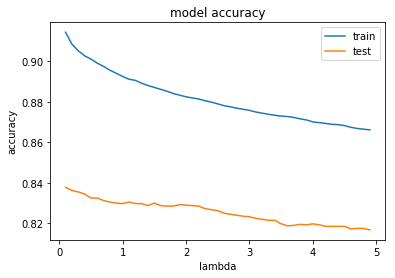

In [24]:
train_accracy = list()
test_accracy = list()
lambd = list()
for i in np.arange(0.1,5.0,0.1):
    model1 = MultinomialNB(alpha=i)
    model1.fit(X_train_feature,y_train)

    y_pred = model1.predict(X_train_feature)
    y_test_pred = model1.predict(X_test_feature)
    
    lambd.append(i)
    train_accracy.append(accuracy_score(y_train, y_pred))
    test_accracy.append(accuracy_score(y_test, y_test_pred))
    
    final = pd.DataFrame({'lambda':lambd,'train_accracy':train_accracy,'test_accracy':test_accracy})
       
plt.plot(final['lambda'],final['train_accracy'])
plt.plot(final['lambda'],final['test_accracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('lambda')
plt.legend(['train', 'test'], loc='upper right')
plt.show()